# The Mandatory Exam Assignment. Autumn 2022. 

## Exercise 1

The original code:

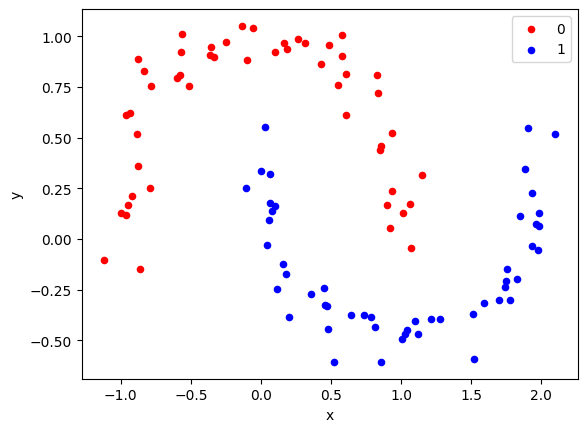

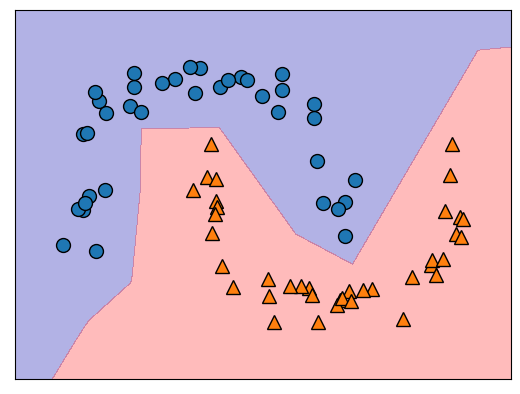

In [81]:
# -*- coding: utf-8 -*-
"""
Created on Mon December 9 15:16:37 2018

@author: sila
"""

from sklearn.datasets import make_moons;
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

from matplotlib.colors import ListedColormap, colorConverter

cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

from matplotlib import pyplot
from pandas import DataFrame

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None,
                      linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines


# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=12)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

pyplot.show()


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10])
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()









Running the code like above, show two plots. The first plot shows all the moons, colored by their cluster. The second plot shows the decision boundary of the model. From this second plot, we can see it does a decent job at predicting the correct cluster, but at the same time, it does not fully capture the shape of the dataset.

There are a number of hyperparameters we can tweak in order to improve the accuracy of the model. We will try the following:
- Number of hidden layers and the density
- Regularization term

Much of the code is about plotting. The interesting part is this:
```python
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10])
```

We can make the following changes:

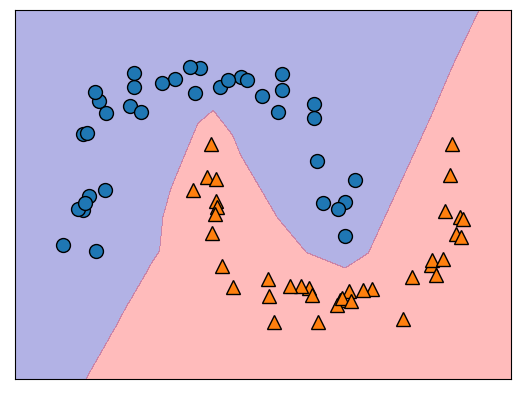

In [109]:
# Deeper and wider network
hidden_layers = [20, 20, 20]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers)
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

A wider and deeper hidden layer allow the model to create a more complex prediction function. The plot shows that the model does a better job at capturing the shape of the dataset.

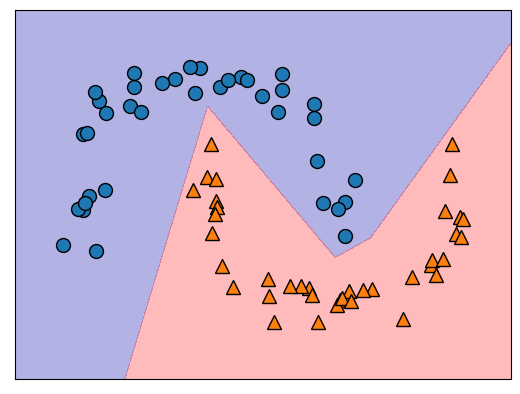

In [105]:
# Thinner and more shallow network
hidden_layers = [5]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers)
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

Here we see that it is possible to approximate a good solution with a very small network. A single hidden layer with 5 nodes. 5 seems to work really well on the dataset, while `5 < x < 10` gives weird results. I do not know why 5 captures the data so well.
From these plots, we can conclude the deeper net provides a better solution. Performance is not an issue on the dataset.

We can also adjust the regularization term.

Alpha:  1


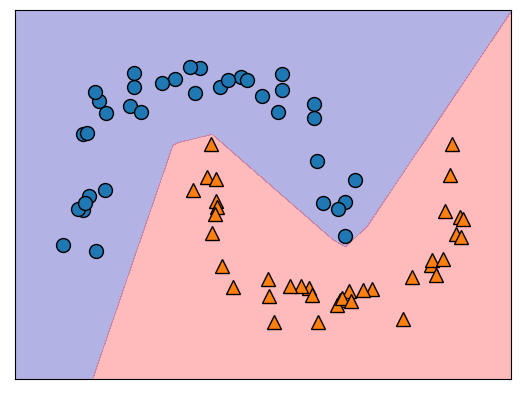

Alpha:  0.5


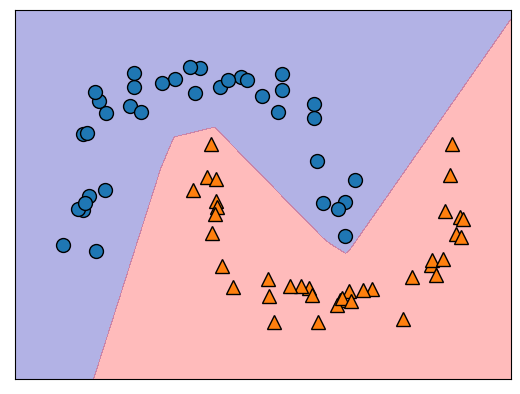

Alpha:  0.1


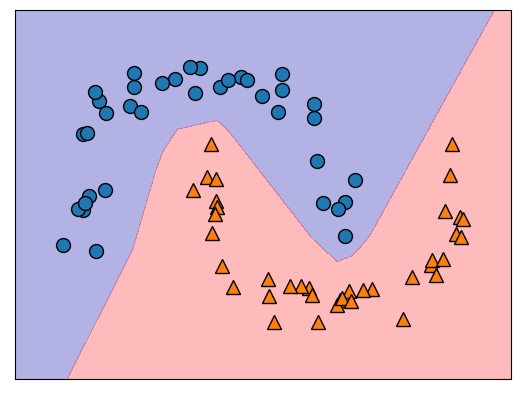

Alpha:  0.01


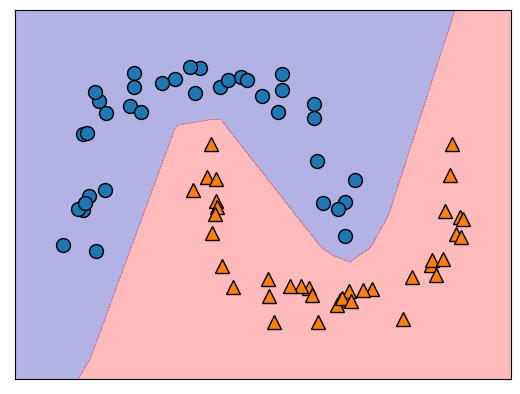

Alpha:  0.001


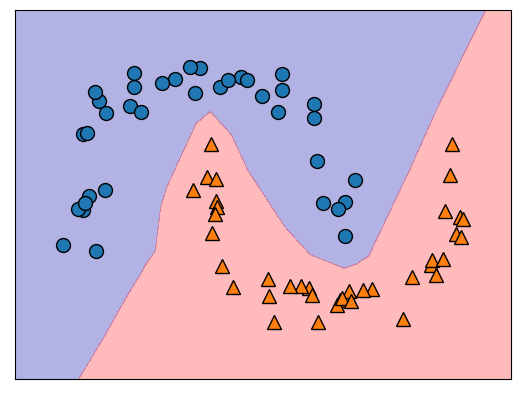

Alpha:  0.0001


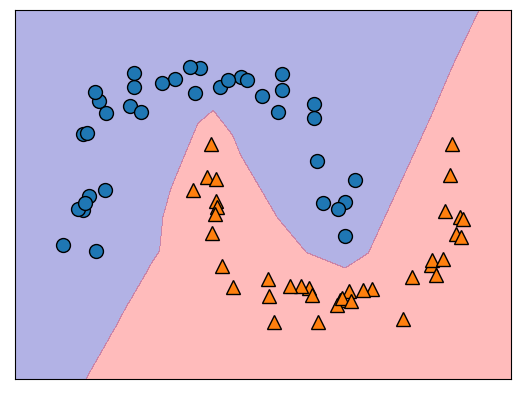

In [119]:
hidden_layers = [20, 20, 20]
for alpha in (1, 0.5, 0.1, 0.01, 0.001, 0.0001):
    print("Alpha: ", alpha)
    mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers, alpha=alpha, max_iter=10000)
    mlp.fit(X_train, y_train)

    plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
    discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

    pyplot.show()